# Projekt PRiAD \- analiza klasy wydolności organizmu \- Rafał Pyłko i Michał Jagodziński

Projekt został wykonany na podstawie wiedzy zawartej  w notatnikach dostarczonych nam na laboratorium oraz przykładowego rozwiązania na platformie kaggle, którego elementy pomogły nam w klasyfikacji.

[https://www.kaggle.com/code/ronesye/body\-performance\-multiclass\-classification](https://www.kaggle.com/code/ronesye/body-performance-multiclass-classification) 

## Biblioteki i pakiety, których będziemy używać podczas analizy:



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.cluster.hierarchy import linkage, ward, fcluster
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Analiza eksploracyjna



<span style='font-size:medium'>Poniżej wczytujemy dane z pliku .csv do ramki "data" za pomocą pakietu pandas. Następnie wyświetlamy 5 pierwszych i ostatnich wierszy, aby dowiedzieć się jak zorganizowane są dane.</span>

<span style='font-size:medium'>Kolejny krok to zliczenie obiektów, klas i atrybutów, z którymi będziemy pracować i sprawdzenie, czy nie ma braków w analizowanych danych.</span>



In [3]:
file_url = 'https://raw.githubusercontent.com/Haribs147/PRIAD/main/bodyPerformance.csv'
data = pd.read_csv(file_url)

In [4]:
data.head()

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
0  27.0      M      172.3      75.24        21.3       80.0     130.0   
1  25.0      M      165.0      55.80        15.7       77.0     126.0   
2  31.0      M      179.6      78.00        20.1       92.0     152.0   
3  32.0      M      174.5      71.10        18.4       76.0     147.0   
4  28.0      M      173.8      67.70        17.1       70.0     127.0   

   gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  
0       54.9                     18.4            60.0          217.0     C  
1       36.4                     16.3            53.0          229.0     A  
2       44.8                     12.0            49.0          181.0     C  
3       41.4                     15.2            53.0          219.0     B  
4       43.5                     27.1            45.0          217.0     B

In [5]:
data.tail()

age gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
13388  25.0      M      172.1       71.8        16.2       74.0     141.0   
13389  21.0      M      179.7       63.9        12.1       74.0     128.0   
13390  39.0      M      177.2       80.5        20.1       78.0     132.0   
13391  64.0      F      146.1       57.7        40.4       68.0     121.0   
13392  34.0      M      164.0       66.1        19.5       82.0     150.0   

       gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm class  
13388       35.8                     17.4            47.0          198.0     C  
13389       33.0                      1.1            48.0          167.0     D  
13390       63.5                     16.4            45.0          229.0     A  
13391       19.3                      9.2             0.0           75.0     D  
13392       35.9                      7.1            51.0          180.0     C

In [6]:
print("Obiekty - ", data.shape[0])

kl = data.iloc[:,-1]
print("Klasy - ", kl.unique().shape[0])

for i in list(kl.unique()):
    print("Obiekty w klasie ", i, " - ", len(data[data['class'] == i]))

print("Atrybuty - ", data.shape[1])

print("Braki - ", data.isnull().sum().sum())

Obiekty -  13393
Klasy -  4
Obiekty w klasie  C  -  3349
Obiekty w klasie  A  -  3348
Obiekty w klasie  B  -  3347
Obiekty w klasie  D  -  3349
Atrybuty -  12
Braki -  0


<span style='font-size:medium'>Z powyższych operacji o zbiorze danych dowiedzieliśmy się następujących informacji:</span>

1. <span style='font-size:medium'>Mamy dane o 13393 ludziach</span>
2. <span style='font-size:medium'>Każdy badany został opisany atrybutami: wiek, płeć, wzrost \[cm\], waga \[kg\], procent tkanki tłuszczowej, rozkurczowe ciśnienie krwi, skurczowe ciśnienie krwi, siła chwytu, skłon na siedząco, ilość brzuszków, skok w dal \[cm\]</span>
3. <span style='font-size:medium'>Na podstawie atrybutów, ludzi podzielono na 4 klasy: A, B, C i D \(na kaggle napisane jest, że A oznacza najbardziej wydolne organizmy, a D najmniej\)</span>
4. <span style='font-size:medium'>Nie ma żadnych wartości null w danych</span>



In [7]:
print(data.describe())

                age     height_cm     weight_kg    body fat_%     diastolic  \
count  13393.000000  13393.000000  13393.000000  13393.000000  13393.000000   
mean      36.775106    168.559807     67.447316     23.240165     78.796842   
std       13.625639      8.426583     11.949666      7.256844     10.742033   
min       21.000000    125.000000     26.300000      3.000000      0.000000   
25%       25.000000    162.400000     58.200000     18.000000     71.000000   
50%       32.000000    169.200000     67.400000     22.800000     79.000000   
75%       48.000000    174.800000     75.300000     28.000000     86.000000   
max       64.000000    193.800000    138.100000     78.400000    156.200000   

           systolic     gripForce  sit and bend forward_cm  sit-ups counts  \
count  13393.000000  13393.000000             13393.000000    13393.000000   
mean     130.234817     36.963877                15.209268       39.771224   
std       14.713954     10.624864                 8.45

<span style='font-size:medium'>Następnie zajmiemy się zrobieniem mapy korelacji</span></span><span style='font-size:medium'>, aby zobaczyć, które atrybuty są ze sobą najbardziej skorelowane, a które najmniej. Pozwoli nam to na ocenienie wartości pojedynczych atrybutów.</span>


<span style='font-size:medium'>Aby zrobić heat mapę korelacji trzeba zamienić atrybuty "</span><span style='font-size:medium'><u>gender</u></span><span style='font-size:medium'>" i "</span><span style='font-size:medium'><u>class</u></span><span style='font-size:medium'>" na liczby. Robimy to w prosty sposób, poprzez przyporządkowanie kobietom liczby 0, a mężczyznom 1. </span>

<span style='font-size:medium'>Klasy zamieniamy od A do D na 1 do 4. Co oznacza, że klasa 1 jest najlepsza a 4 najgorsza. </span><span style='font-size:medium'>**W dalszej części analizy posługujemy się numerycznymi nazwami klas.**</span>



In [8]:
data = data.replace({'gender': 'F'}, 0)
data = data.replace({'gender': 'M'}, 1)
data = data.replace({'class': 'A'}, 1)
data = data.replace({'class': 'B'}, 2)
data = data.replace({'class': 'C'}, 3)
data = data.replace({'class': 'D'}, 4)
data.head()

age  gender  height_cm  weight_kg  body fat_%  diastolic  systolic  \
0  27.0       1      172.3      75.24        21.3       80.0     130.0   
1  25.0       1      165.0      55.80        15.7       77.0     126.0   
2  31.0       1      179.6      78.00        20.1       92.0     152.0   
3  32.0       1      174.5      71.10        18.4       76.0     147.0   
4  28.0       1      173.8      67.70        17.1       70.0     127.0   

   gripForce  sit and bend forward_cm  sit-ups counts  broad jump_cm  class  
0       54.9                     18.4            60.0          217.0      3  
1       36.4                     16.3            53.0          229.0      1  
2       44.8                     12.0            49.0          181.0      3  
3       41.4                     15.2            53.0          219.0      2  
4       43.5                     27.1            45.0          217.0      2

<Axes: >

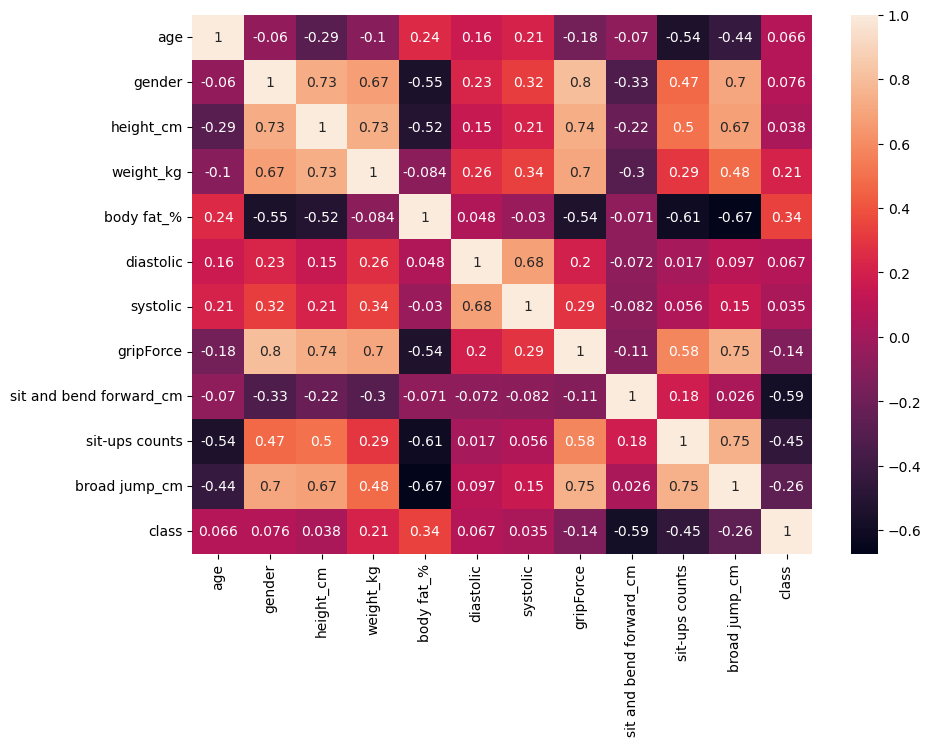

In [9]:
#tworzenie heatmapy
kor = data.corr()
plt.figure(figsize=(10,7), dpi = 100)
sns.heatmap(kor,annot = kor)

<span style='font-size:medium'>Jak widać na macierzy korelacji powyżej najsilniej skorelowane są atrybuty </span><span style='font-size:medium'><u>gender </u></span><span style='font-size:medium'>oraz </span><span style='font-size:medium'><u>gripForce </u></span><span style='font-size:medium'>co wynika z prostego powodu, że mężczyźni pod względem siłowym \(jeżeli nie są to ćwiczenia uwzględniające wagę, takie jak brzuszki\) są silniejsi od kobiet.</span>

<span style='font-size:medium'>Następnie atrybuty </span><span style='font-size:medium'><u>broad jump</u></span><span style='font-size:medium'> oraz </span><span style='font-size:medium'><u>grip force</u></span><span style='font-size:medium'> i </span><span style='font-size:medium'><u>sit\-ups counts</u></span><span style='font-size:medium'> także są silnie skorelowane, gdzie skok w dal jest silnie skorelowany z siłą uchwytu oraz ilością brzuszków. Taki rezultat ma bardzo logiczne przełożenie na rzeczywiste życie. Człowiek potrafiący daleko skoczyć, powinien cechować się dużą ilością brzuszków i ogólnym rozwinięciem fizycznym. Macierz korelacji potwierdza taką prostą dedukcję.</span>

<span style='font-size:medium'>Najmniejsza korelacja występuje w atrybutach </span><span style='font-size:medium'><u>diastolic </u></span><span style='font-size:medium'>\(ciśnienie rozkurczowe\) oraz </span><span style='font-size:medium'><u>sit\-ups counts</u></span><span style='font-size:medium'> \(ilość brzuszków\). Co oznacza że ciśnienie krwi nie miało dużego wpływu na klasę wydolności. Bardziej przyglądając się macierzy i analizując ciśnienie rozkurczowe i skurczowe, można zauważyć, że są one bardzo mało skorelowane z innymi atrybutami oprócz z samym sobą. Także osoby mający wysokie ciśnienie rozkurczowe są podatne na posiadanie wysokiego ciśnienia skurczowego \(i na odwrót\)</span>

<span style='font-size:medium'>Jedną z najmniejszych korelacji wykazuje </span><span style='font-size:medium'><u>weight\_kg</u></span><span style='font-size:medium'> oraz body </span><span style='font-size:medium'><u>fat\_%</u></span><span style='font-size:medium'> co się wydaje bardzo dziwnie, ale najprawdopodobniej spowodowane jest to tym, że osoba niska, może ważyć np. 60 kg \(co na osobę 145 cm jest sporo\) i przez to mieć duży procent tkanki tłuszczowej.</span>


F:\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


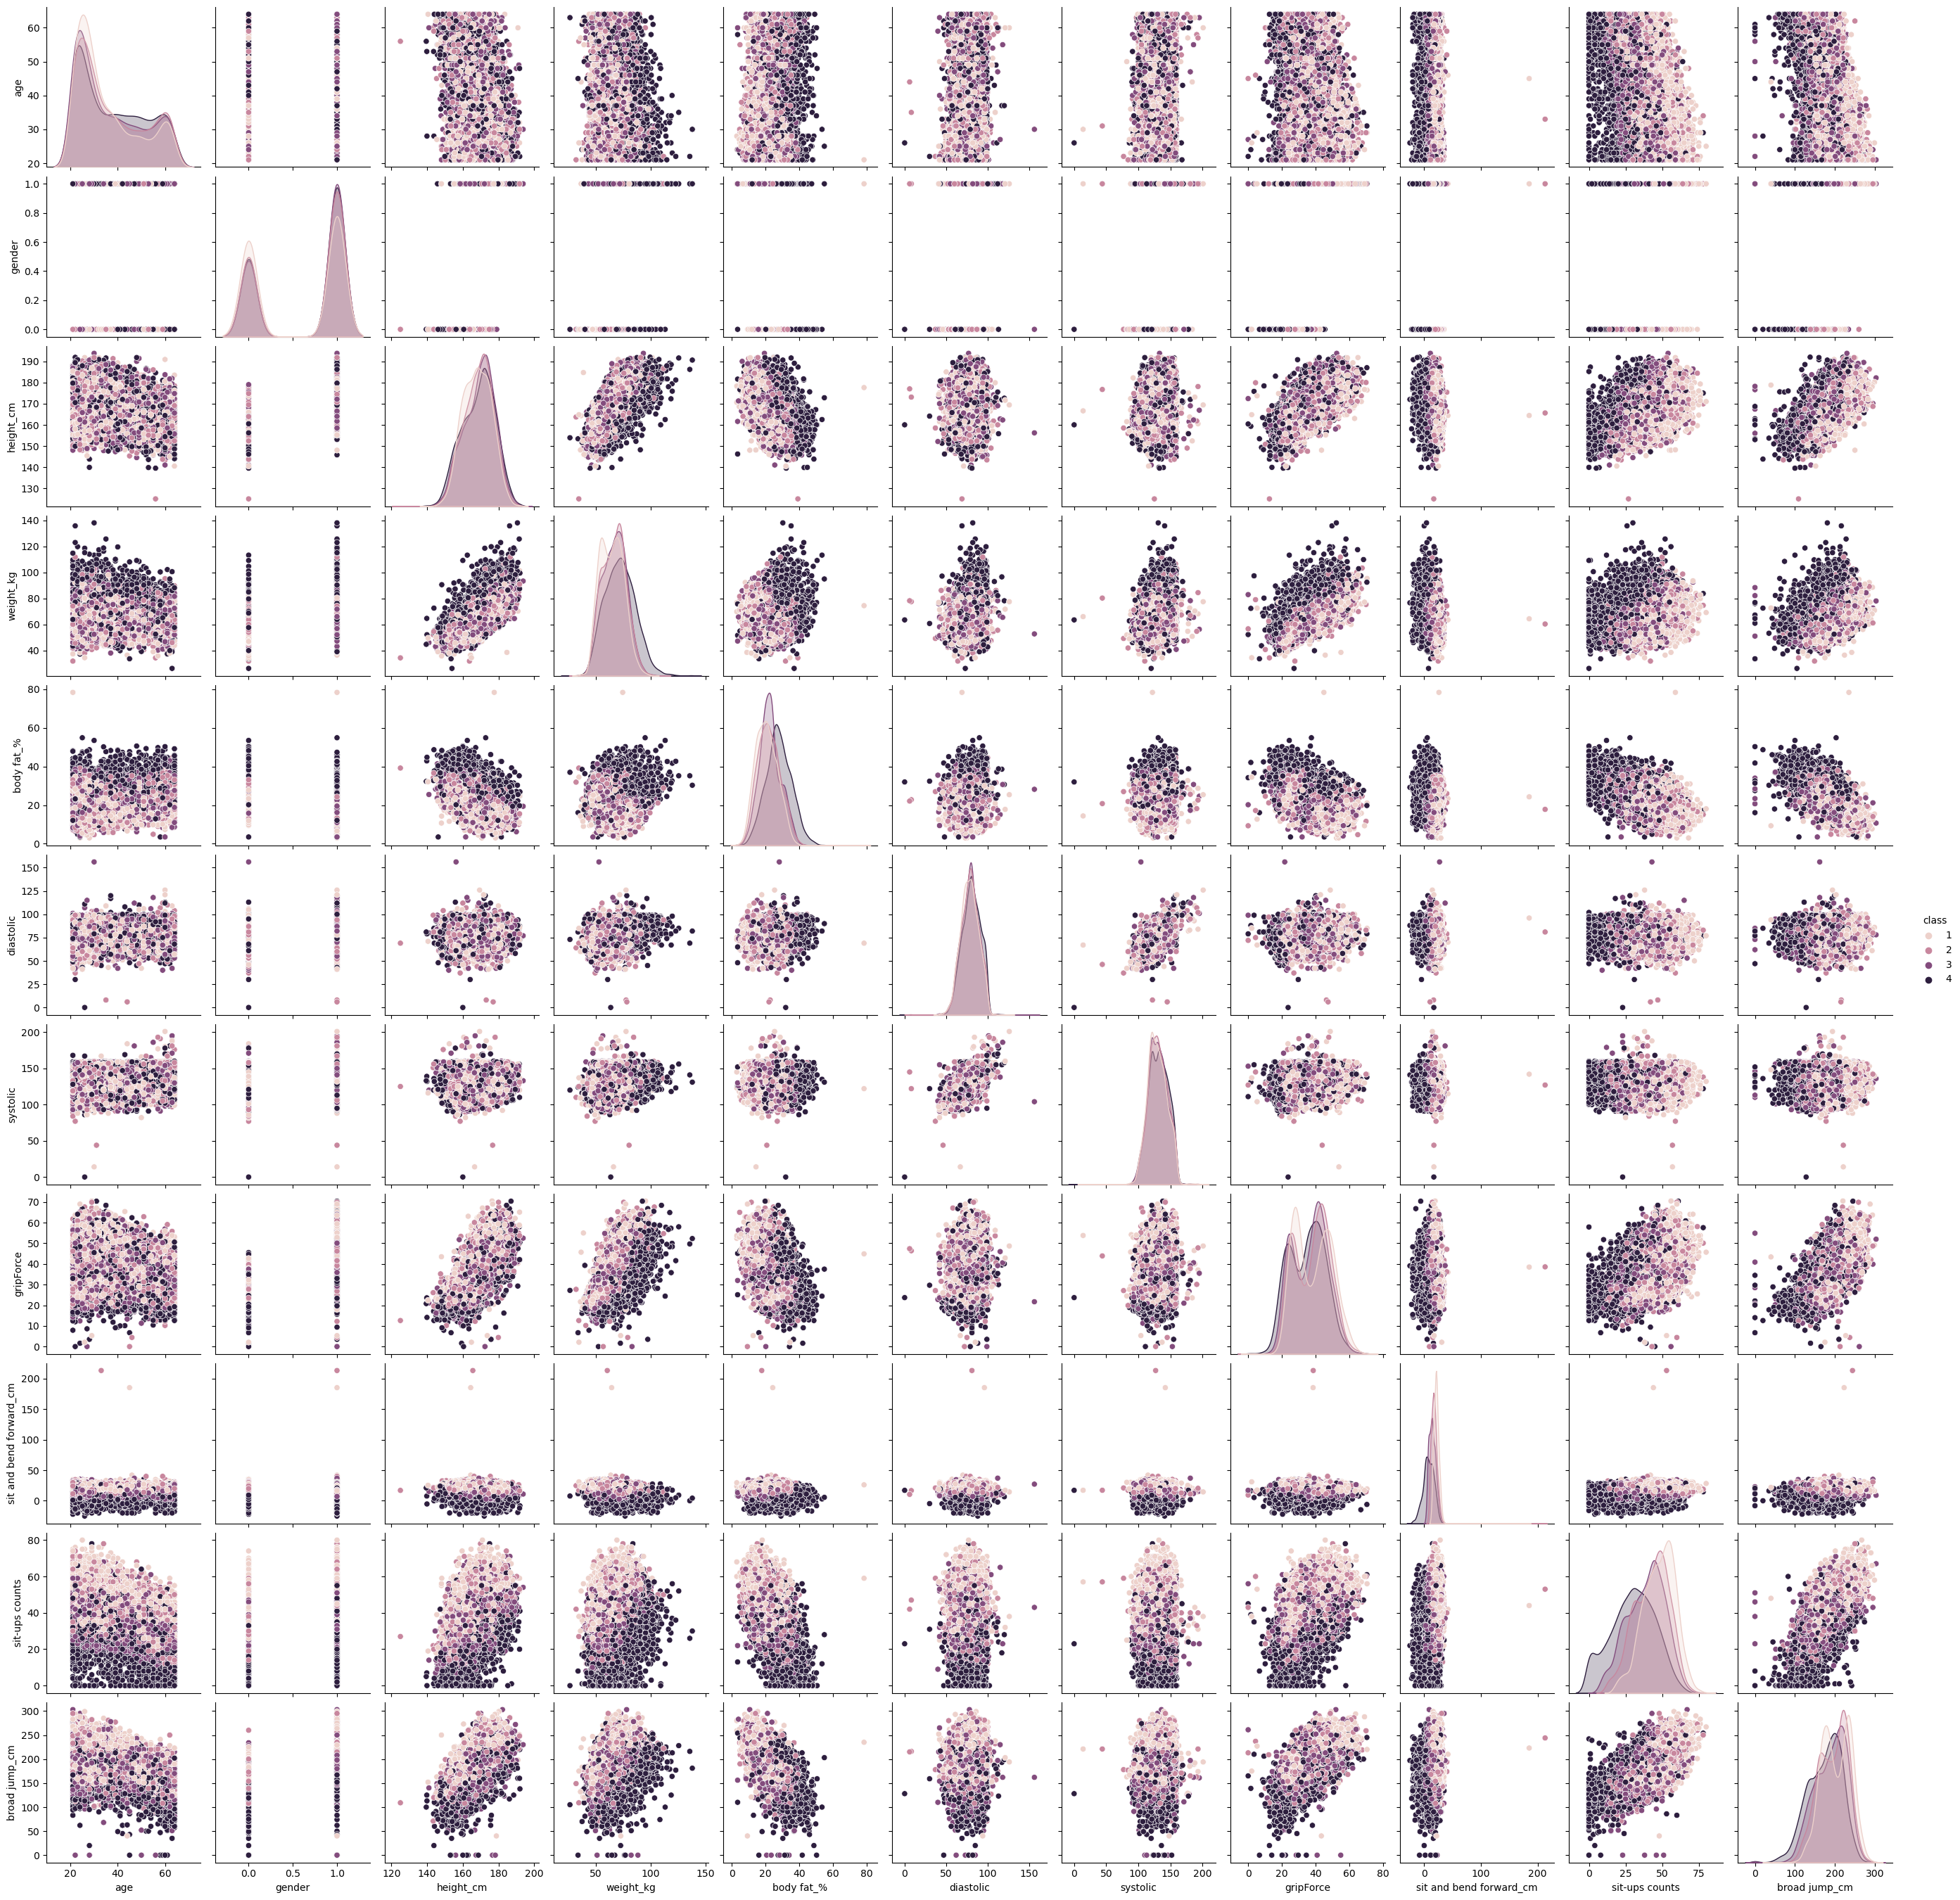

In [10]:
sns.pairplot(data, kind="scatter", hue="class")

<span style='font-size:medium'>Powyższe wykresy par atrybutów pokazują, że wyniki są bardzo zbieżne i ciężko doszukać się jakichś naturalnych grup w tym zbiorze danych. Histogramy każdego z atrybutów w większości się pokrywają.</span>

<span style='font-size:medium'>Już na tym etapie można podejrzewać, że klasyfikacja metodą k\-NN będzie miało problemy z poprawnym klasyfikowaniem, niezależnie od wybranej pary atrybutów.</span>

<span style='font-size:medium'>Do rozróżnienia klas najlepsze wydają się być </span><span style='font-size:medium'><u>sit\-ups counts</u></span><span style='font-size:medium'>, </span><span style='font-size:medium'><u>sit and bend forward</u></span><span style='font-size:medium'> oraz </span><span style='font-size:medium'><u>body fat %</u></span><span style='font-size:medium'>, ponieważ można tam dostrzec jakieś granice między klasami.</span>

<span style='font-size:medium'>Atrybutami, które nie zawierają za wiele przydatnych do klasyfikacji informacji są z pewnością </span><span style='font-size:medium'><u>diastolic</u></span><span style='font-size:medium'>, </span><span style='font-size:medium'><u>systolic </u></span><span style='font-size:medium'>i </span><span style='font-size:medium'><u>height</u></span><span style='font-size:medium'>. Ich histogramy pokrywają się niemal w 100%.</span>



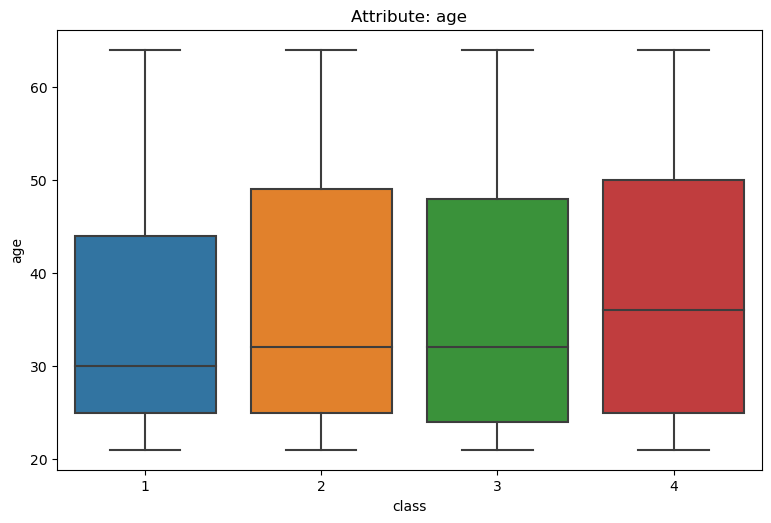

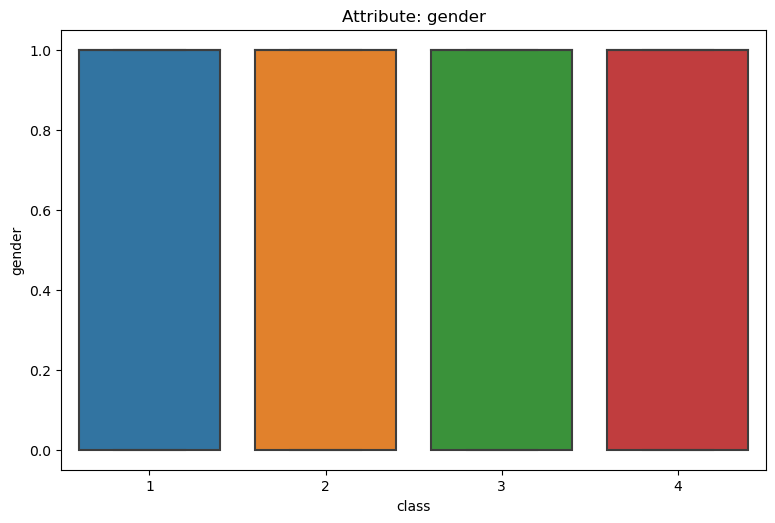

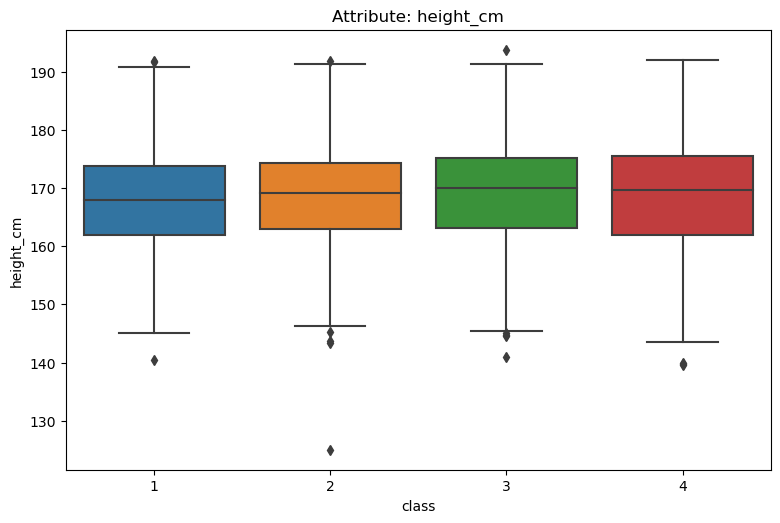

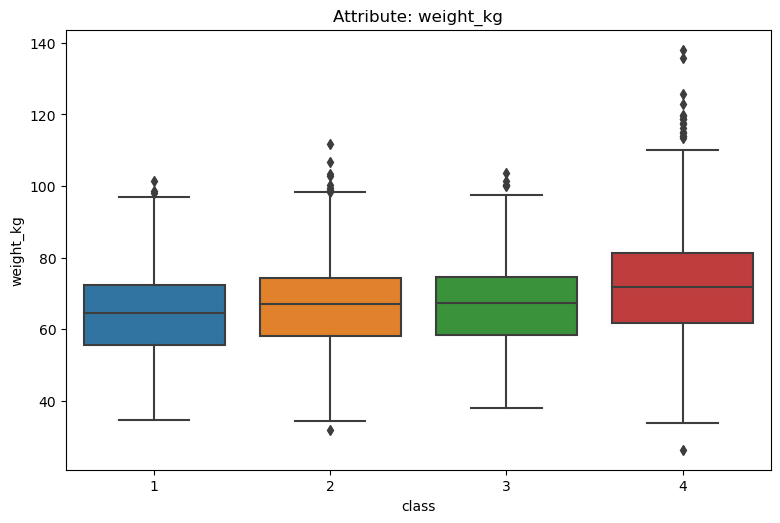

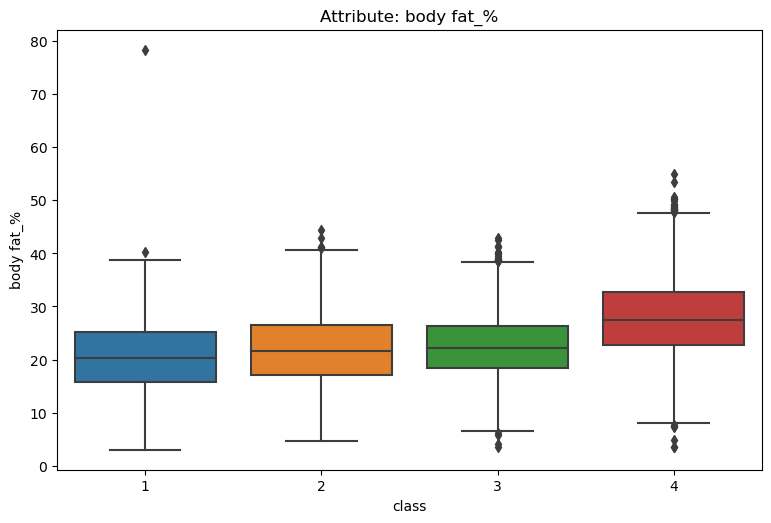

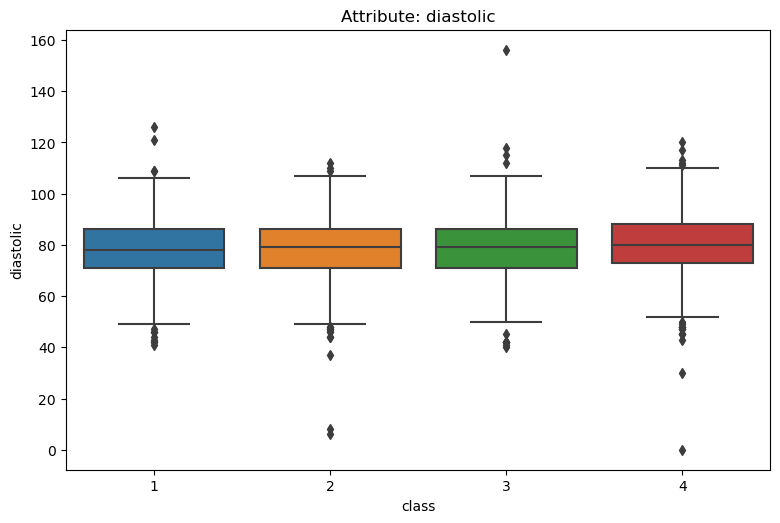

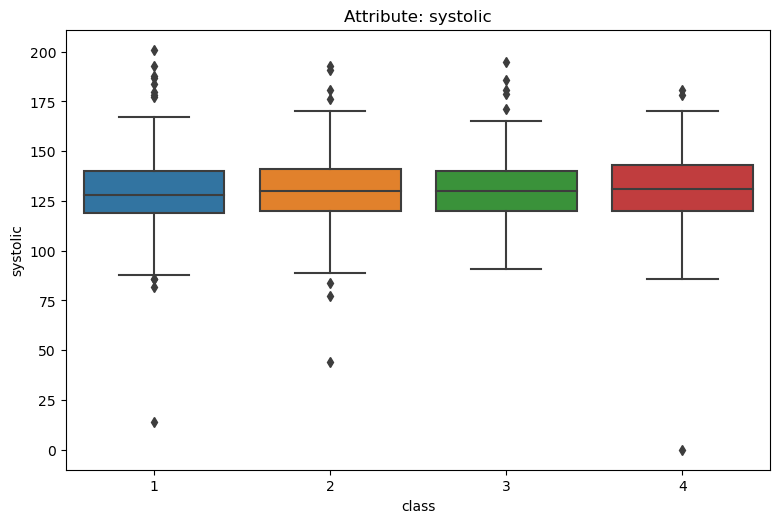

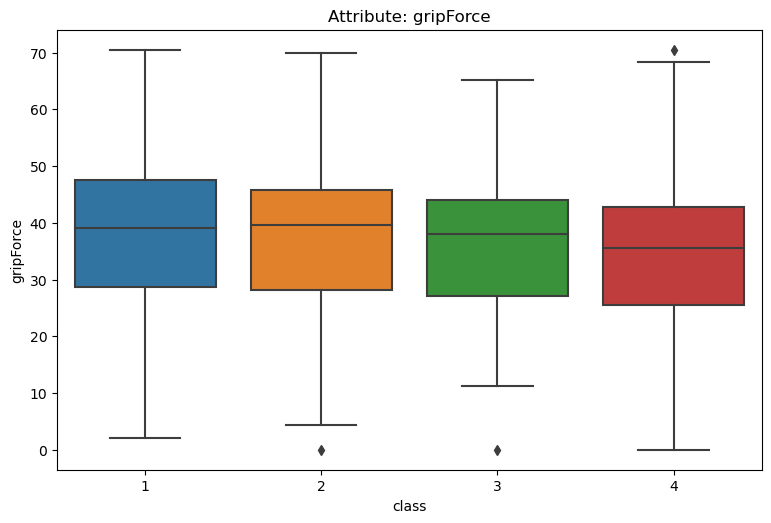

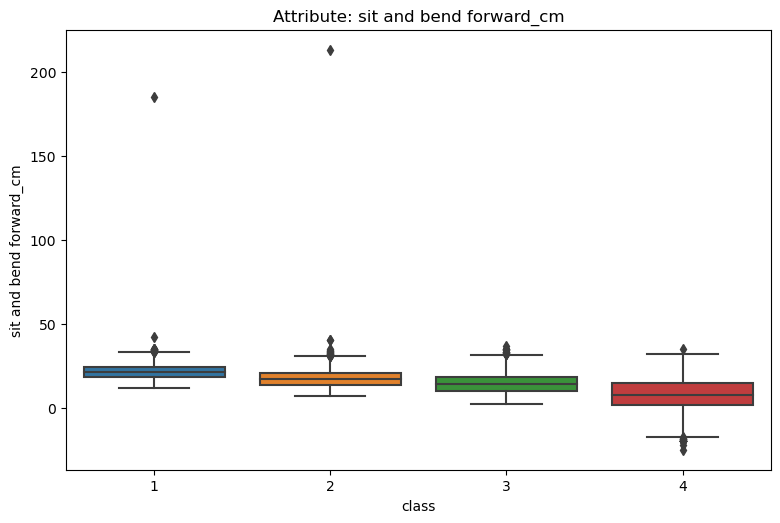

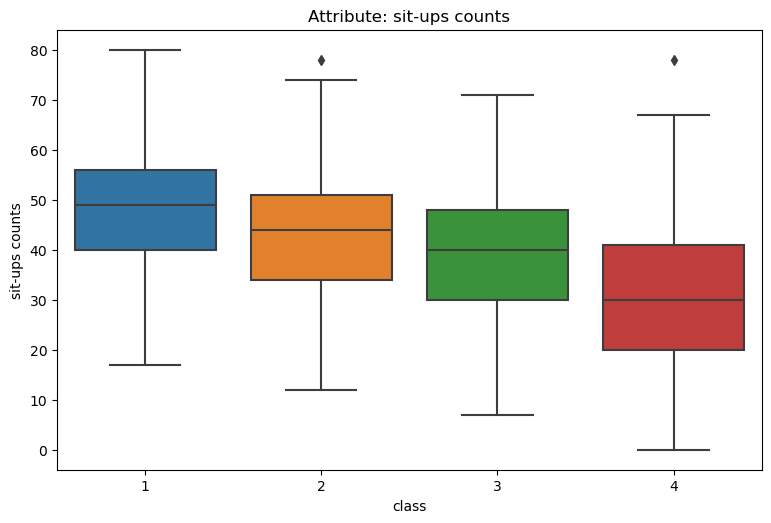

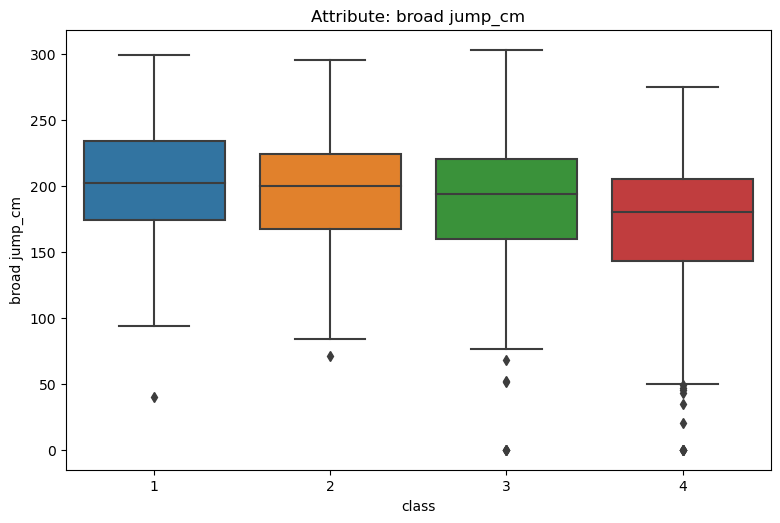

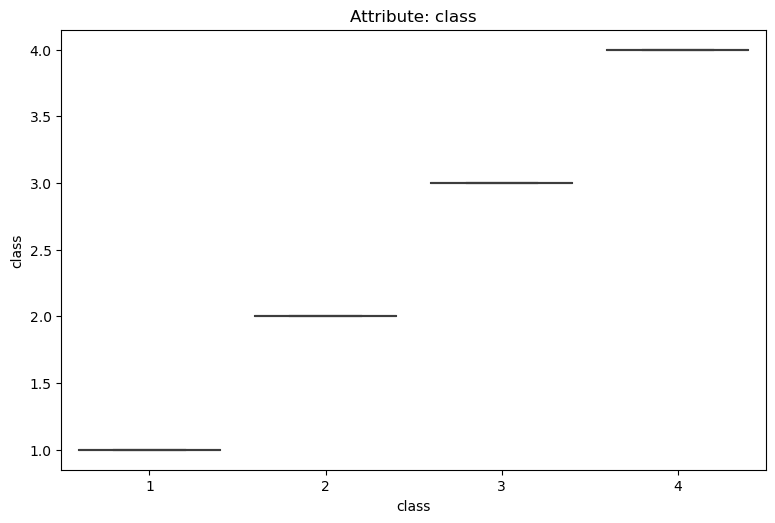

In [11]:
i = 1
for attribute in data.columns:
    plt.figure(figsize=(20, 40))
    plt.subplot(6, 2, i)
    plt.title(f'Attribute: {attribute}')
    sns.boxplot(x='class', y=attribute, data=data)

    i = i + 1
    plt.show()

<span style='font-size:medium'>Podział na klasy w zależności od poszczególnych atrybutów nie daje nam żadnych satysfakcjonujących informacji. Wartości atrybutów pokrywają się dla różnych klas. Ciężko jest z niego wyciągnąć jakieś wartościowe informacje, ale można spróbować.</span>

<span style='font-size:medium'>Można wywnioskować, że jeżeli osoba waży powyżej około 80 kg będzie najprawdopodobniej należeć do klasy nr. 4. To samo tyczy się </span><span style='font-size:medium'><u>body fat %</u></span><span style='font-size:medium'>, gdzie powyżej 30% również występuje duże prawdopodobieństwo klasy 4.</span>

<span style='font-size:medium'>Można zauważyć także na wykresie dla </span><span style='font-size:medium'><u>sit\-ups</u></span><span style='font-size:medium'> pewne wyróżnienie, albowiem jeżeli osoba robi ponad 52 brzuszki, z dużym prawdopodobieństwem znajduje się już w 1 klasie, a jeżeli poniżej 30, w klasie czwartej. </span>

<span style='font-size:medium'>Atrybut </span><span style='font-size:medium'><u>sit and bend forward</u></span><span style='font-size:medium'> pozwala zaobserwować, że obiekt mający wynik poniżej 0 znajdzie się w klasie 4. Reszta atrybutów nie daje nam zbyt wiele informacji.</span>

<span style='font-size:medium'>Z tego wynika, że atrybuty </span><span style='font-size:medium'><u>body fat %</u></span><span style='font-size:medium'> \(procent tkanki tłuszczowej\), </span><span style='font-size:medium'><u>sit ups count</u></span><span style='font-size:medium'> \(liczba brzuszków\) oraz </span><span style='font-size:medium'><u>sit and bend forward</u></span><span style='font-size:medium'> \(skłon na siedząco\) są najbardziej wartościowe przy rozróżnianiu klas wydolności organizmu.</span>

<span style='font-size:medium'>Drugim wnioskiem jest, że klasy 1 i 4 wyróżniają się na tyle dobrze, że powinniśmy potrafić przydzielać do nich testowe obiekty z wyższą dokładnością niż do klas 2 i 3, które są ciężko rozróżnialne. Być może 4 klasy nie są optymalną liczbą grup dla tego zbioru danych.</span>


# Klasyfikacja



<span style='font-size:medium'>Klasyfikacje dokonujemy metodami: naiwnej klasyfikacji Bayesa, k najbliższych sąsiadów oraz drzewa decyzyjnego. Wykorzystujemy także metodę walidacji krzyżowej</span>

<span style='font-size:medium'>Dzięki funkcji crossValidation za pomocą podanego klasyfikatora na wejściu \("cla"\) oraz metody walidacji krzyżowej, obliczamy dokładność klasyfikacji oraz pokazujemy macierze pomyłek w formie heatmapy dla każdego podziału walidacji krzyżowej.</span>

<span style='font-size:medium'>Dzięki użyciu StratifiedKFold\(n\_splits=5\), dane są dzielone na 5 zestawów treningowych i testowych. W każdej iteracji jedno z pięciu podziałów służy jako zestaw testowy, a pozostałe cztery jako zestaw treningowy. Proces ten powtarza się 5 razy, więc każdy zestaw danych zostanie użyty jako zbiór testowy dokładnie raz. CrossValidation zwraca nam dwa elementy, net\_mat oraz acc. Net\_mat jest to zsumowana macierz pomyłek dla każdych iteracji kroswalidacji. Acc to tablica zawierająca wszystkie dokładności poszczególnych iteracji.</span>

<span style='font-size:medium'>Zadaniem funkcji avegcon jest przedstawienie końcowych wyników kroswalidacji wcześniej wykonanej. Przyjmuje ona trzy argumenty: classifier, matrix, i ac. Pierwszy argument to nazwa klasyfikatora, drugi to macierz pomyłek która została zwrócona w funkcji crossValidation \("net\_mat"\), a trzeci to tablica dokładności dla poszczególnych iteracji kroswalidacji \("acc"\). Funkcja wyświetla raport dla danego klasyfikatora, podając średnią dokładność oraz prezentuje całkowitą macierz pomyłek, uwzględniając wszystkie iteracje.</span>



In [12]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold
features =  ['age', 'gender', 'height_cm', 'weight_kg', 'body fat_%','gripForce', 'sit and bend forward_cm', 'sit-ups counts','broad jump_cm']
X = data[features].values
Y = data['class'].values

def crossValidation(cla):
    #i = 1
    skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    acc=[] 
    net_mat=np.zeros((4, 4))
    for train_index, test_index in skf.split(X,Y):
        X_train=X[train_index]
        X_test=X[test_index]
        Y_train=Y[train_index]
        Y_test=Y[test_index]

        cla.fit(X_train, Y_train)  
        Y_testPred = cla.predict(X_test) 

        testAccuracy = metrics.accuracy_score(Y_test, Y_testPred)
        print("Test Accuracy", testAccuracy*100)
        acc.append(testAccuracy)   

        matrix1 = confusion_matrix(Y_test, Y_testPred)
        #sum of the total confusion matirx
        net_mat=net_mat+matrix1
        #plt.subplot(6, 2, i)

        plot_confusion_matrix(matrix1,class_names=['A', 'B','C','D'],show_normed=True, colorbar=True, show_absolute=True,figsize=(4,4))   
        #i = i + 1
        plt.show()
    return net_mat,acc

def avegcon(classifier,matrix,ac):

    print("Report for the "+ classifier +" classifier")
    accc=sum(ac) / len(ac)
    print("average accuracy ", accc )        
    
    plot_confusion_matrix(matrix,show_normed=True ,colorbar=True,class_names=['A','B','C','D'], show_absolute=True,figsize=(4,4))

    

<span style='font-size:medium'>Gaussowski naiwny klasyfikator Bayes'a daje najlepsze efekty, gdy rozkład wartości atrybutów jest rozkładem gaussa. Jak dla każdego klasyfikatora Bayes'a, zakładamy niezależność cech od siebie. Gdy pojawi się nowy przykład, algorytm oblicza prawdopodobieństwo przynależności do każdej z klas na podstawie wzoru Bayes'a. Na podstawie prawdopodobieństa nowy obiekt jest przydzielany do odpowiedniej klasy.</span>



application of Naive Bayes classfication 
Test Accuracy 55.95371407241508


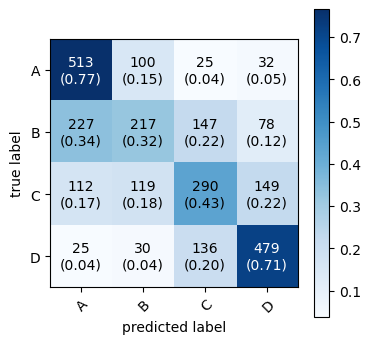

Test Accuracy 53.75139977603583


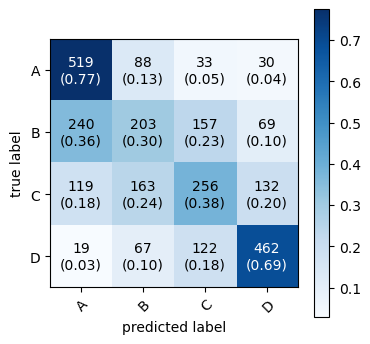

Test Accuracy 55.09518477043673


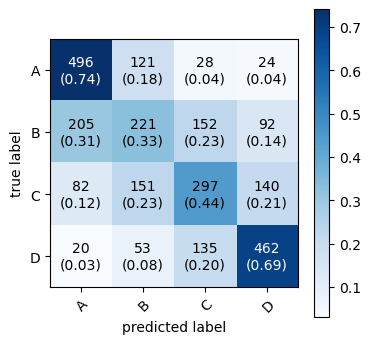

Test Accuracy 54.779686333084385


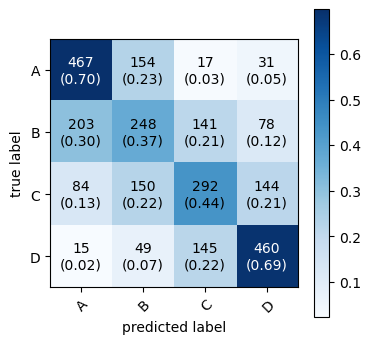

Test Accuracy 52.875280059746075


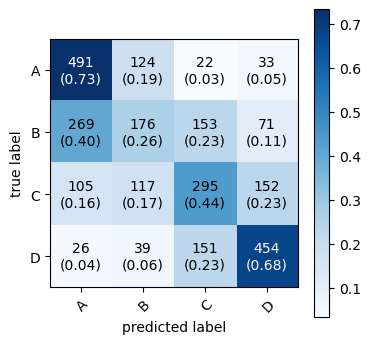

In [14]:
#Gaussian Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
gaus=GaussianNB()
print("application of Naive Bayes classfication ")
NB_matrix,NB_acc = crossValidation(gaus)

Report for the Naive_bays_classifier classifier
average accuracy  0.5449105300234363


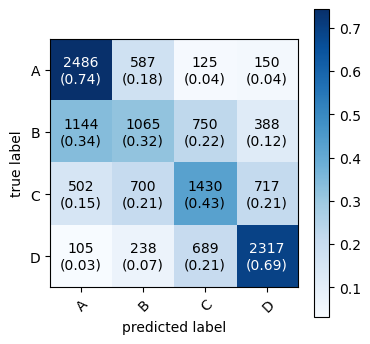

In [15]:
avegcon("Naive_bays_classifier", NB_matrix ,NB_acc)

<span style='font-size:medium'>Klasyfikacja k\-najbliższych sąsiadów klasyfikuje nowe przypadki na podstawie najbliższych sąsiadów znanego zbioru treningowego, liczy on odległości od wszystkich punktów i patrzy do jakiej klasy należy k najbliższych punktów. Nowy obiekt jest przypisywany do klasy, do której należy największa ilość jego sąsiadów.</span>



application of K nearest neigbhour classification 
Test Accuracy 62.112728630085854


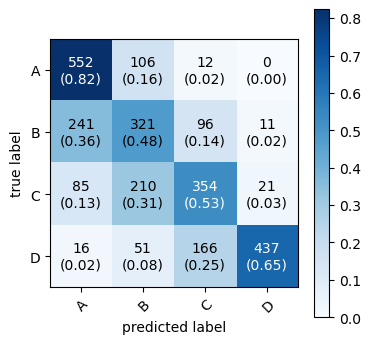

Test Accuracy 62.4113475177305


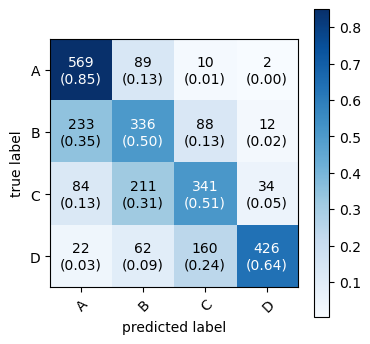

Test Accuracy 62.63531168346398


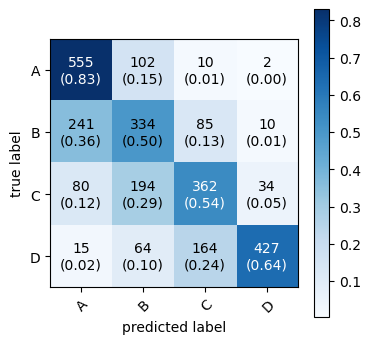

Test Accuracy 62.54667662434653


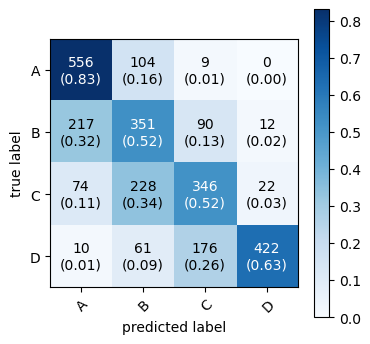

Test Accuracy 64.26437640029873


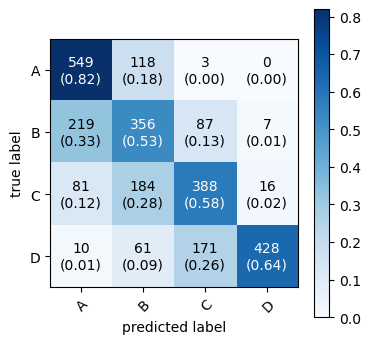

In [16]:
#K Nearest neighbour classifier
from sklearn.neighbors import KNeighborsClassifier
neigh=KNeighborsClassifier(n_neighbors = 30)
print("application of K nearest neigbhour classification ")
KNN_matrix,KNN_acc = crossValidation(neigh)

Report for the K_Nearest_neighbour classifier
average accuracy  0.6279408817118511


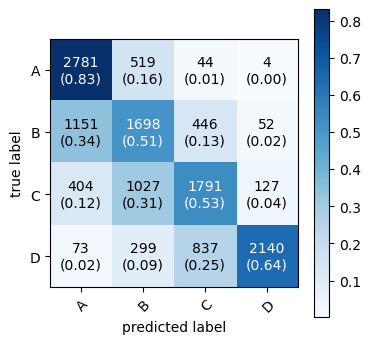

In [17]:
avegcon("K_Nearest_neighbour", KNN_matrix, KNN_acc)

<span style='font-size:medium'>W klasyfikatorze drzewa decyzyjnego w każdym węźle drzewa dzielimy dane na podstawie jakiejś cechy.</span>

<span style='font-size:medium'>Po zbudowaniu drzewa używamy go do klasyfikacji nowych danych, przemieszczając się od korzenia drzewa do liścia, podejmując decyzje na podstawie wartości cech. Wynikiem testu w węźle drzewa decyzyjnego są rozłączne zbiory, które następnie wędrują do dzieci danego węzła i są ponownie testowane, dopóki nie zostaną liściami. </span>



application of Decision Tree classificaiton 
Test Accuracy 64.46435237028743


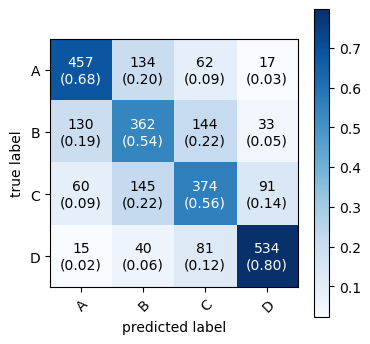

Test Accuracy 64.6883165360209


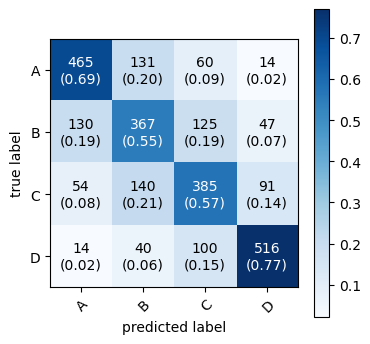

Test Accuracy 63.49384098544233


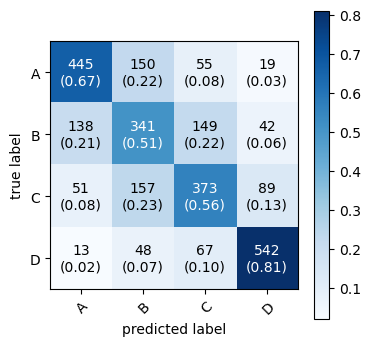

Test Accuracy 64.97386109036594


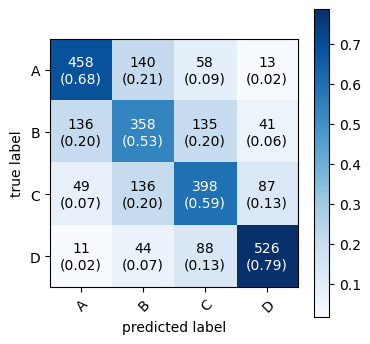

Test Accuracy 64.93651979088872


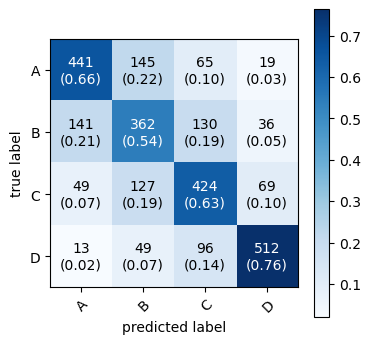

In [19]:
#Decision_Tree_classifier
from sklearn.tree import DecisionTreeClassifier
treemodel=DecisionTreeClassifier()
print("application of Decision Tree classificaiton ")
DTree_matrix,DTree_acc=crossValidation(treemodel)

Report for the Decision_Tree_classifier classifier
average accuracy  0.6451137815460106


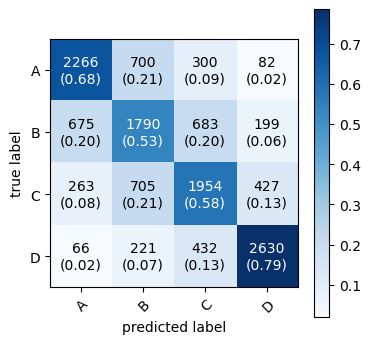

In [20]:
avegcon('Decision_Tree_classifier', DTree_matrix, DTree_acc)

<span style='font-size:medium'>Podsumowując wyniki poszczególnych klasyfikacji:</span>

<span style='font-size:medium'>Bayes: 54.5%</span>

<span style='font-size:medium'>K\-najbliższych sąsiadów: 62.7%</span>

<span style='font-size:medium'>Drzewo decyzyjne: 64.5%</span>

<span style='font-size:medium'>Jak widać najlepsze wyniki są dla metody klasyfikacji drzewem decyzyjnym. </span>

<span style='font-size:medium'>Klasyfikator Bayes'a okazał się najmniej skutecznym, podejrzewamy, że może to być spowodowane sporą zależnością między atrybutami w naszym zbiorze danych.</span>

<span style='font-size:medium'>Wyniki dla klasyfikatora k\-najbliższych sąsiadów zdecydowanie się poprawiły i prawie dorównały drzewu decyzyjnemu po usunięciu atrybutów systolic i diastolic. Rozkład tych atrybutów dla każdej z klas był niemalże identyczny, co musiało wpływać negatywnie na wyniki klasyfikacji.</span>

<span style='font-size:medium'>Nie udało nam się osiągnąć satysfakcjonującej dokładności klasyfikacji, ale głównym tego czynnikiem z naszego punktu widzenia jest niezrozumiała klasyfikacja pierwotna. Atrybuty przybierają bardzo podobne histogramy dla każdej klasy. Niektóre cechy przybierały dziwne i nierealne wyniki, np.: </span><span style='font-size:medium'><u>sit and bend forward</u></span><span style='font-size:medium'> mieście się w zakresie od \-25cm do 213cm. Ciężko zrozumieć co ten atrybut opisuje, a jego rola w tworzeniu klasyfikatora jest kluczowa. Z dotychczas zdobytymi umiejętnościami zbiór danych był trudny do przeanalizowania. Po obserwacji wykresów par atrybutów postawiliśmy hipotezę, że klasyfikator k\-NN może nie być efektywny, ponieważ punkty na wykresach tworzyły pojedyńcze skupiska ogromnej liczby punktów. Okazało się jednak, że klasyfikator ten nie wykazał się wcale gorszą dokładnością klasyfikacji niż pozostałe użyte klasyfikatory. </span>


# Grupowanie hierarchiczne



<span style='font-size:medium'>Poniżej pogrupujemy nasz zbiór danych metodą aglomeracyjną, czyli przez iteracyjne łączenie punktów w większe grupy. Aby to wykonać pozbywamy się atrybutu decyzyjnego, wyznaczamy połączenia między łączonymi grupami i odległość progową, która będzie decydowała o przynależności do grupy. Następnie przypisujemy grupę każdemu obiektowi według wcześniej wyznaczone odległości progowej. Następnie wyświetlamy podział na klasy dany nam z góry i nowy wyznaczony aglomeracyjnie dla porównania.</span>



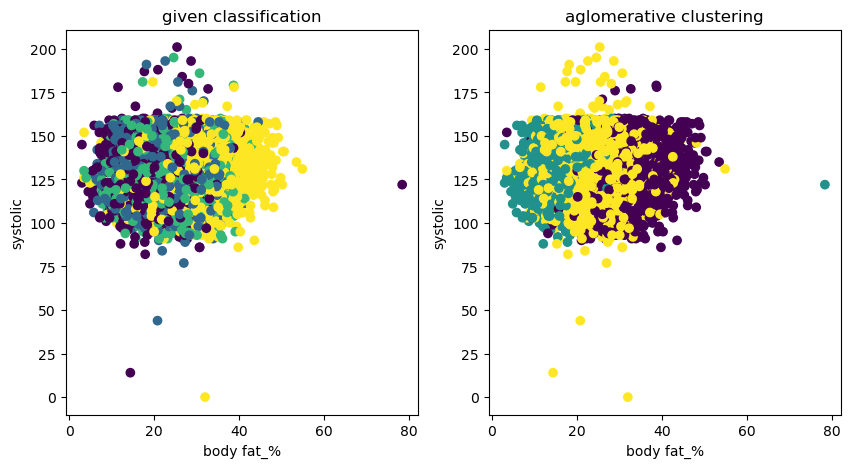

In [21]:
g_data = data.drop(columns = ['class'])
prog_proc = 70
groups = linkage(g_data, method = 'ward', metric = 'euclidean')
prog = prog_proc*max(groups[:,2])/100
g_data['group'] =  fcluster(groups, prog, criterion = 'distance')

plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plt.title('given classification')
plt.xlabel('body fat_%')
plt.ylabel('systolic')
plt.scatter(x = g_data['body fat_%'], y = g_data['systolic'], c = data['class'].astype('category').cat.codes)

plt.subplot(1,2,2)
plt.title('aglomerative clustering')
plt.xlabel('body fat_%')
plt.ylabel('systolic')
plt.scatter(x = g_data['body fat_%'], y = g_data['systolic'], c = g_data['group'])

<span style='font-size:medium'>Grupowanie aglomeracyjne podzieliło zbiór danych na 3 grupy i ten wynik wydaje się być jak najbardziej logiczny. W poprzednich etapach analizy stwierdziliśmy, że klasy skrajne \(1 i 4\) da się  odróżnić od pozostałych z większą dokładnością, a klasy 2 i 3 mocno się zbiegają, więc połączenie ich w jedną jest sensowne. Do grupowania wybraliśmy atrybuty </span><span style='font-size:medium'><u>body fat\_%</u></span><span style='font-size:medium'> i </span><span style='font-size:medium'><u>systolic</u></span><span style='font-size:medium'>, ponieważ cechowały się małą korelacją. Najlepsze rezultaty wychodzą dla grupowania metodą 'ward', pozostałe metody miały tendencję do tworzenia jednej dużej grupy.</span>

